# Notebook for making confusion matrices

In [280]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os, os.path
import sys
#sys.path.append('..\phase1_analysis')
#from phase1_data_analysis import GetUncertaintyLabels

## Read in data

In [281]:
ntn_subjects = pd.read_csv('data/result.csv')

## Have to pick high and low thresholds

In [282]:
LOWTHRES = 0.14 #lower threshold
HIGHTHRES = 0.21 #higher threshold


In [283]:
def GetUncertaintyLabels(matrix_ntn_subjects):
    '''Helper function for generating confusion matrix labels'''
    labels = []
    nrows, ncols = matrix_ntn_subjects.shape
    for i in range(0,nrows):
        col_sum = matrix_ntn_subjects.iloc[:,i].sum()
        for k in range(0,ncols):
            val = matrix_ntn_subjects.iloc[k,i]
            n_val = (val/col_sum.astype(float))*100
            val_percent_round = "%.1f" % n_val
            lab_n = '%.1f%%'%n_val
            lab_v = '%d/%d'%(val,col_sum)
            lab='%.1f%%\n%d/%d' % (n_val, val, col_sum)
            labelc= str(lab_n)+"\n"+str(lab_v)
            label = f"{str(lab_n)} {str(lab_v)}"
            labels.append(str(lab))
    labels_array = np.asarray(labels)
    labels_val = labels_array.reshape(5,5)
    labels_new = labels_val.T
    return labels_new


In [284]:
types = ['Skimming','Cascade','Through-Going\nTrack','Starting\nTrack','Stopping\nTrack'] #labels

## Original (no cuts) user vs. MC 

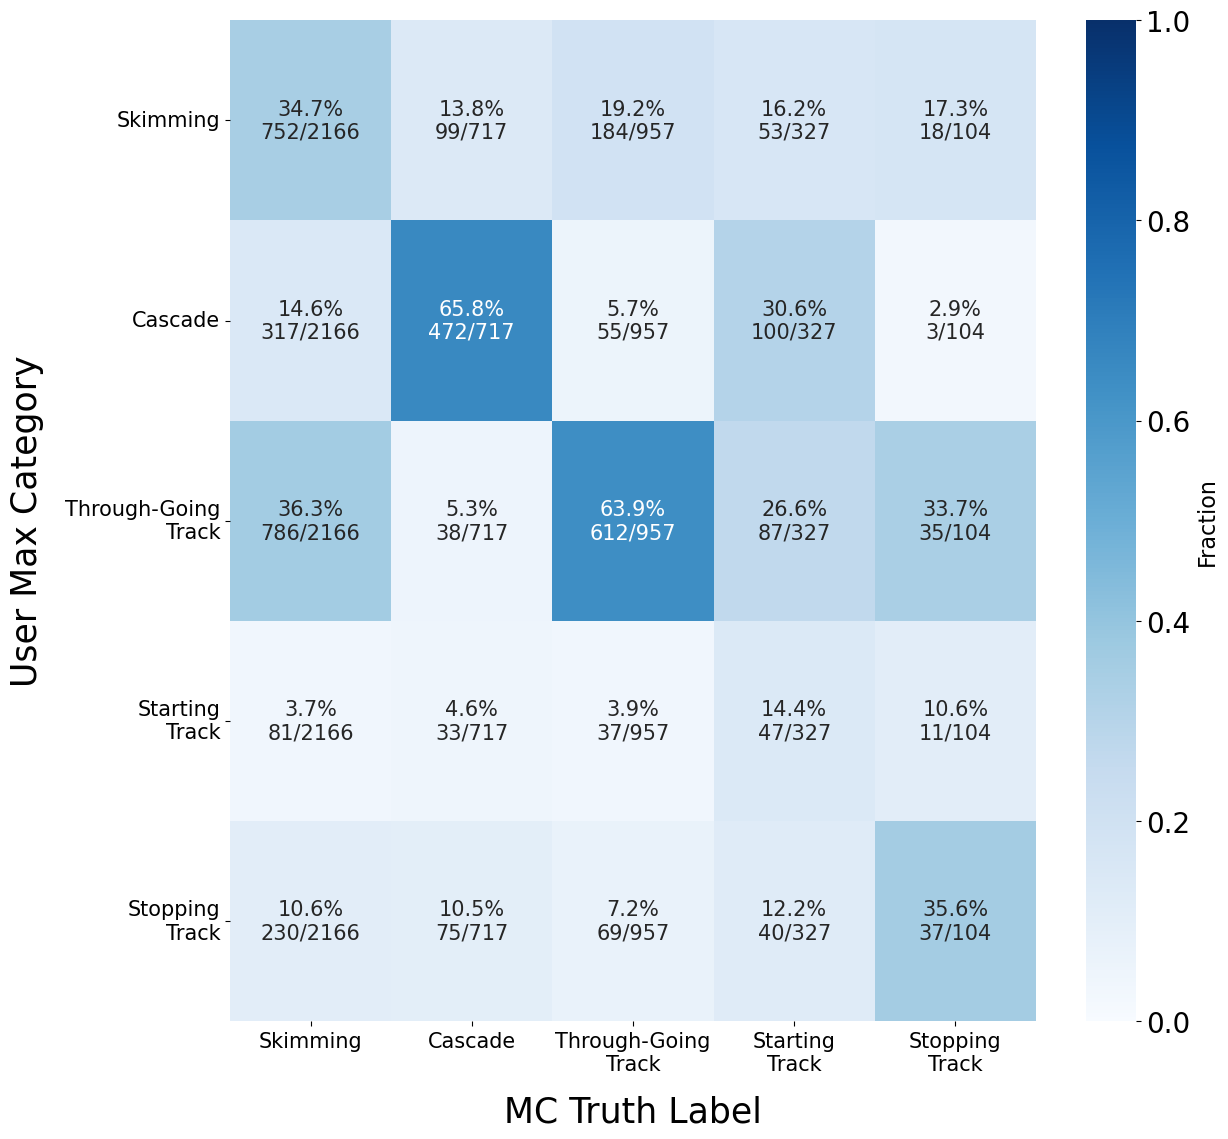

In [285]:
conf_norm = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['truth_classification'], rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
conf = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['truth_classification'], rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
plt.ylabel('User Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
plt.show()

### Figure out which events to cut

In [286]:
ntn_subjects = ntn_subjects[(ntn_subjects['qratio'] < LOWTHRES) | (ntn_subjects['qratio'] > HIGHTHRES)] #get rid of events in middle domain
qratio = list(ntn_subjects['qratio'])
corsika_class = list(ntn_subjects['corsika_label'])         #list of corsika classifications
truth_class = list(ntn_subjects['truth_classification'])    #list of truth classifications
tmp = []

for i in range(0, len(ntn_subjects)):
    if (qratio[i] < LOWTHRES):
        tmp.append(truth_class[i])
    else:
        tmp.append(corsika_class[i])
ntn_subjects.insert(0, 'classif', tmp)

accuracy = len(ntn_subjects[ntn_subjects['dnn_classification'] == ntn_subjects['classif']])/len(ntn_subjects)

print('Total agreement between DNN and users: {}'.format(accuracy))
print('Events discarded: {}'.format(4273 - len(ntn_subjects)))


Total agreement between DNN and users: 0.8305836000984979
Events discarded: 212


(0.0, 1000.0)

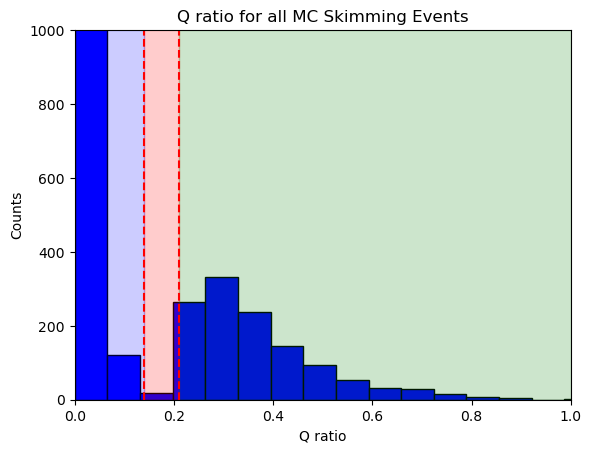

In [287]:
fig, ax = plt.subplots()
ax.hist(qratio, bins=20, color='blue', edgecolor='black')
line1 = ax.plot(np.ones(100)*lim1, np.linspace(0,1000, 100), linestyle='dashed', color='red')
line2 = ax.plot(np.ones(100)*lim2, np.linspace(0,1000, 100), linestyle='dashed', color='red')
#ax.fill_between(len(qratio_skim), min(qratio_skim), max(qratio_skim), where=(qratio_skim > lim1) & (qratio_skim < lim2), alpha=0.5)
ax.axvspan(lowthres, highthres, alpha=0.2, color='red')
ax.axvspan(0, lowthres, alpha=0.2, color='blue')
ax.axvspan(highthres, 1, alpha=0.2, color='green')
#ax.legend([line1, line2], ['lower threshold', 'higher threshold'])

#ax.text((lim1)/2, 500, 'NuGen Label')
#ax.text((1-lim2)/2+lim2, 500, 'Corsika Label')
ax.set_xlabel('Q ratio') 
ax.set_ylabel('Counts')
ax.set_title('Q ratio for all MC Skimming Events')
ax.set_xlim(0,1)
ax.set_ylim(0,1000)

### DNN vs. MC, with cut

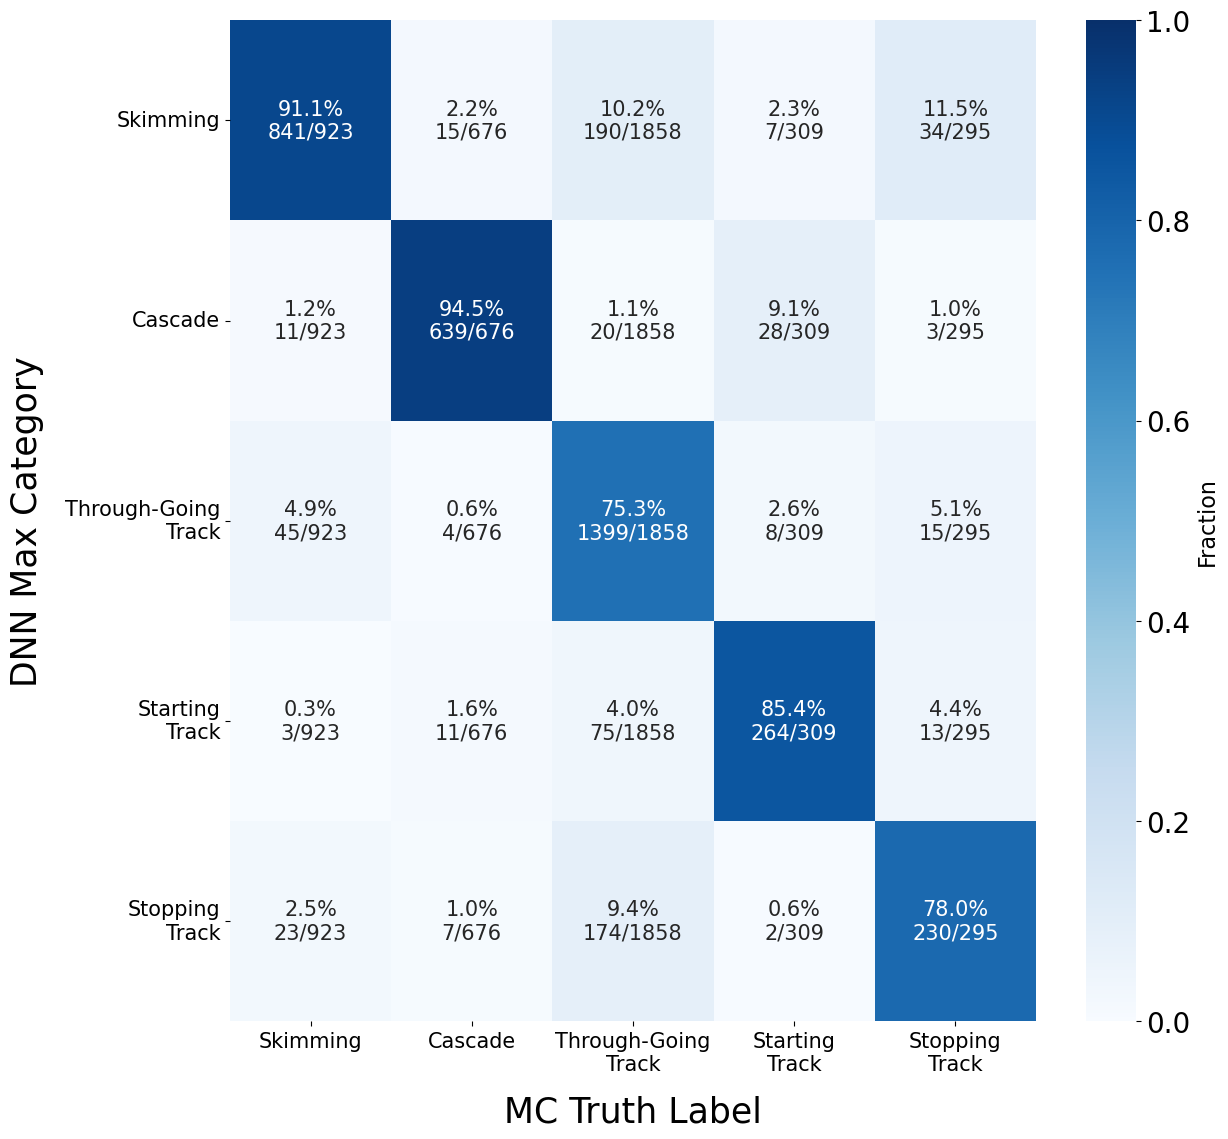

In [288]:
conf_norm = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['classif'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['dnn_classification'], ntn_subjects['classif'], rownames=['DNN Max Category'], colnames=['MC Truth Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('DNN Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
#plt.savefig("ml_user_cm_cut.png")
#plt.title('DNN vs. MC, Qratio < {}'.format(thres))
plt.show()

### User vs. MC, with cut

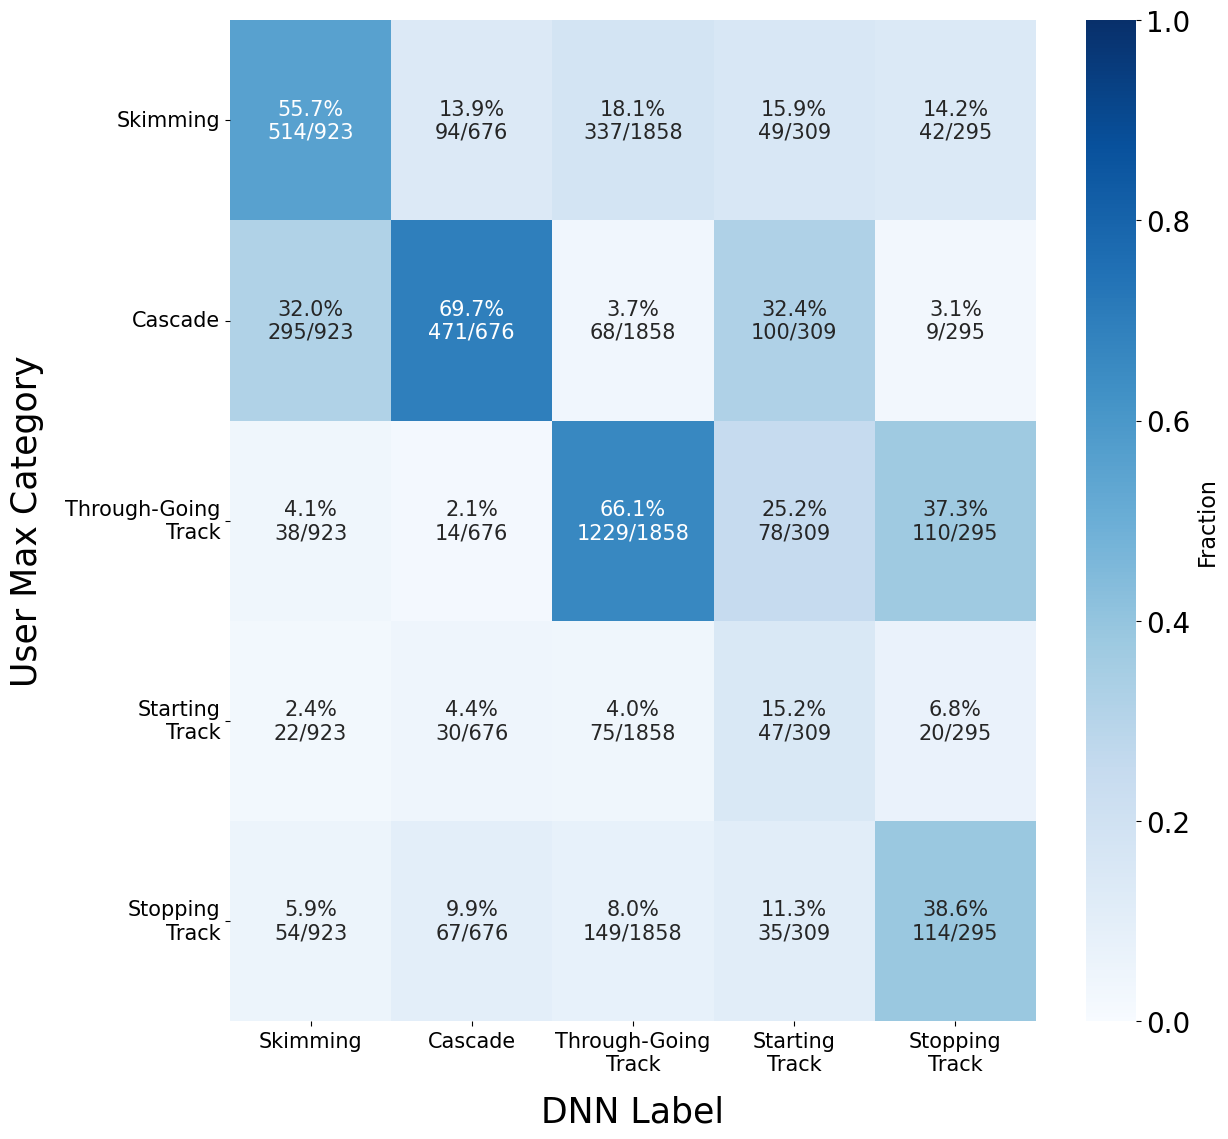

In [289]:
conf_norm = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['classif'], rownames=['User Max Category'], colnames=['DNN Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['classif'], rownames=['User Max Category'], colnames=['DNN Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('User Max Category',fontsize=25,labelpad=15)
plt.xlabel('DNN Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
#plt.savefig("ml_user_cm_cut.png")
#plt.title('DNN vs. MC, Qratio < {}'.format(thres))
plt.show()

### User vs. MC, with cut

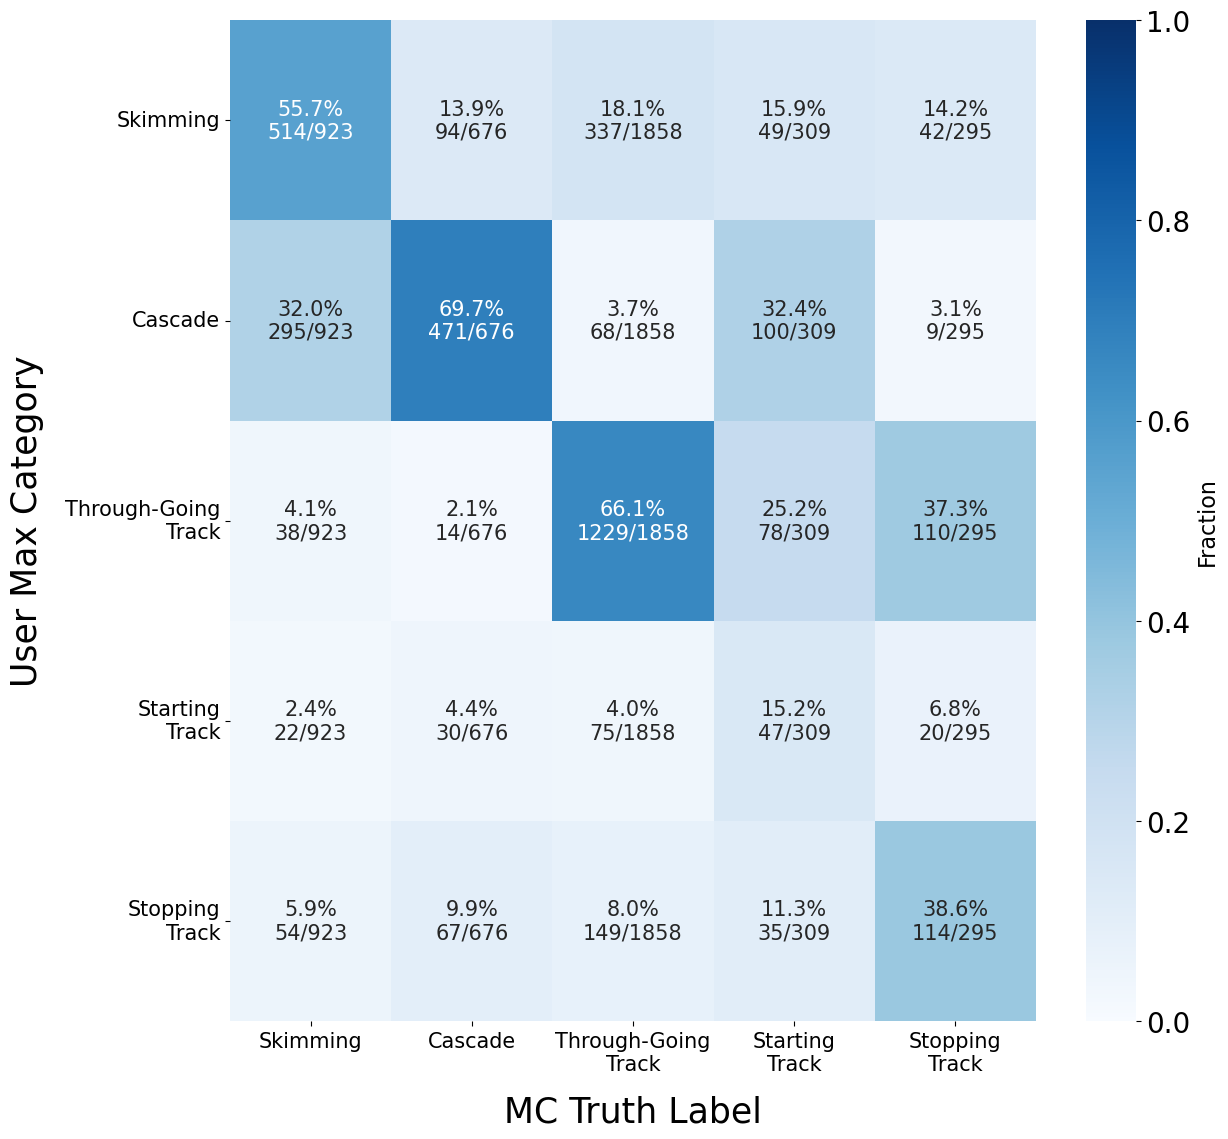

In [290]:
conf_norm = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['classif'], rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False,normalize='columns')
#confusion_matrix_user_ml_55_norm_20ret = confusion_matrix_user_ml_55_norm
conf = pd.crosstab(ntn_subjects['user_classification'], ntn_subjects['classif'], rownames=['User Max Category'], colnames=['MC Truth Label'], margins=False)
fig, ax = plt.subplots(figsize=(13,13))
ax = sns.heatmap(conf_norm, annot=GetUncertaintyLabels(conf), annot_kws={"size": 15}, fmt='',cmap='Blues',xticklabels=types,yticklabels=types,vmin=0.0,vmax=1.0,cbar_kws={'label':'Fraction'})
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.ax.set_ylabel('Fraction',fontsize=16)
#plt.show()
plt.ylabel('User Max Category',fontsize=25,labelpad=15)
plt.xlabel('MC Truth Label',fontsize=25,labelpad=15)
plt.yticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15", va="center")
plt.xticks(np.arange(5)+0.5,types,
           rotation=0, fontsize="15")
#plt.savefig("ml_user_cm_cut.png")
#plt.title('DNN vs. MC, Qratio < {}'.format(thres))
plt.show()